Epoch [1/100] - Train Loss: 2.2301, Validation Loss: 2.1839, Validation Accuracy: 0.2019
Epoch [2/100] - Train Loss: 2.1515, Validation Loss: 2.1422, Validation Accuracy: 0.2283
Epoch [3/100] - Train Loss: 2.0978, Validation Loss: 2.1247, Validation Accuracy: 0.2241
Epoch [4/100] - Train Loss: 2.0543, Validation Loss: 2.0949, Validation Accuracy: 0.2442
Epoch [5/100] - Train Loss: 2.0032, Validation Loss: 2.0689, Validation Accuracy: 0.2590
Epoch [6/100] - Train Loss: 1.9579, Validation Loss: 2.0505, Validation Accuracy: 0.2600
Epoch [7/100] - Train Loss: 1.9200, Validation Loss: 2.0330, Validation Accuracy: 0.2727
Epoch [8/100] - Train Loss: 1.8723, Validation Loss: 2.0257, Validation Accuracy: 0.2558
Epoch [9/100] - Train Loss: 1.8463, Validation Loss: 2.0045, Validation Accuracy: 0.2759
Epoch [10/100] - Train Loss: 1.7945, Validation Loss: 1.9895, Validation Accuracy: 0.2896
Epoch [11/100] - Train Loss: 1.7650, Validation Loss: 1.9931, Validation Accuracy: 0.2886
Epoch [12/100] - Tr

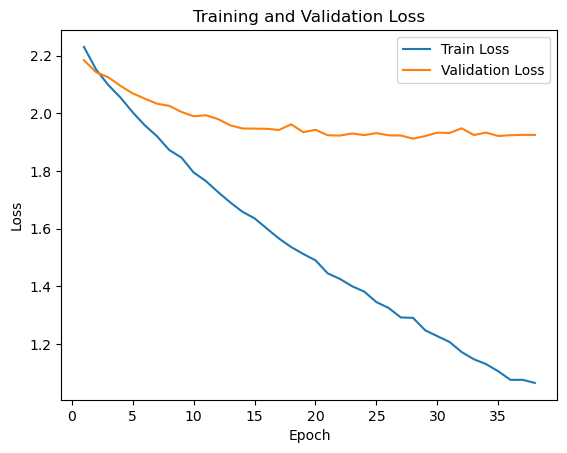

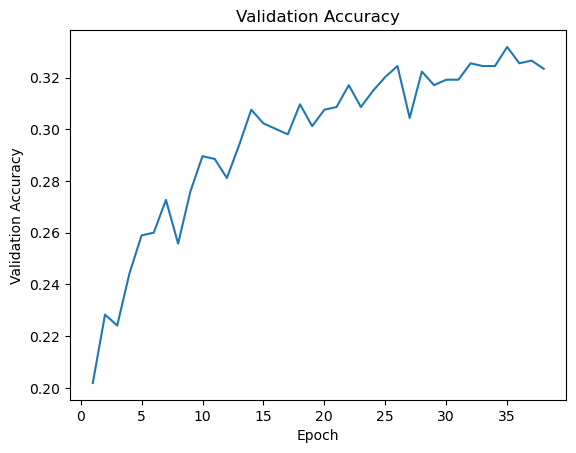

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


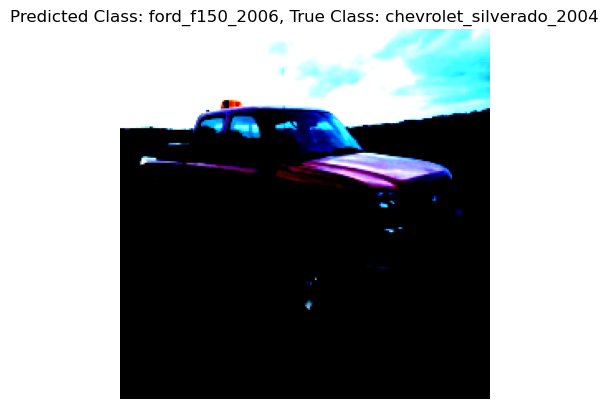

In [19]:

import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the path to the dataset
dataset_dir = r'C:\Users\saaks\Downloads\archive\Dataset\Most_Stolen_Cars'

# Create the training, validation, and test datasets
all_dataset = ImageFolder(dataset_dir, transform=transform)
trainval_dataset, test_dataset = train_test_split(all_dataset, test_size=0.2, random_state=42)
train_dataset, validation_dataset = train_test_split(trainval_dataset, test_size=0.2, random_state=42)

# Create data loaders for efficient batch processing
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


class VehicleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)  # Apply dropout with 50% probability
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x




# Create an instance of your custom model
num_classes = len(all_dataset.classes)
model = VehicleClassifier(num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    validation_loss = running_loss / len(validation_dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)
    
    # Learning rate scheduling
    scheduler.step(validation_loss)
    
    # Print the training and validation metrics for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
    
    # Check for early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_epoch = epoch
        # Save the best model so far
        torch.save(model.state_dict(), 'best_vehicle_classifier_model.pth')
    elif epoch - best_epoch >= patience:
        # No improvement for the specified number of epochs, stop training
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load the best model
model.load_state_dict(torch.load('best_vehicle_classifier_model.pth'))

# Evaluate on the test set
model.eval()
running_loss = 0.0
correct_predictions = 0
total_predictions = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_loss = running_loss / len(test_dataset)
test_accuracy = correct_predictions / total_predictions

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print the test metrics
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plot the training and validation losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure()
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

# Display an example of image input and its predicted class
example_idx = random.randint(0, len(test_dataset) - 1)
example_image, example_label = test_dataset[example_idx]
example_image = example_image.unsqueeze(0).to(device)
example_output = model(example_image)
_, example_predicted = torch.max(example_output, 1)

# Convert the predicted class index to the corresponding class label
class_labels = all_dataset.classes
example_predicted_label = class_labels[example_predicted.item()]

# Display the example image and its predicted class
plt.imshow(example_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f"Predicted Class: {example_predicted_label}, True Class: {class_labels[example_label]}")
plt.axis('off')
plt.show()